In [1]:
Mjj_selection = 1000.

binning=[50, Mjj_selection, 3000.]

#Used just to get some files
vae_loss = 'mae'

# Imports

In [2]:
from __future__ import print_function

import h5py, os, sys, glob, datetime, time, pickle
sys.path.append('../lib')
from glob import glob
import numpy as np
import scipy as sp
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
from matplotlib.colors import LogNorm

from prettytable import PrettyTable

import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np
from progressBar import ProgressBar

from cebefo_style import cebefo_style
cebefo_style()

dnd = []

Welcome to JupyROOT 6.16/00


# Analyze signal region

In [3]:
sample_loc = {'qcd':'qcd_dEta_signalregion_results.h5',
              'AtoZZZ':'AtoHZ_to_ZZZ_13TeV_PU40_results.h5',
              'GtoWW':'RSGraviton_WW_NARROW_13TeV_PU40_results.h5',
              'GtoBtt':'RSGraviton_tt_BROAD_13TeV_PU40_results.h5',
              'GtoNtt':'RSGraviton_tt_NARROW_13TeV_PU40_results.h5'
             }

sample_label = {'qcd':r'QCD',
                'AtoZZZ':r'$A\to ZZZ$',
                'GtoWW':r'$G\to WW$',
                'GtoBtt':r'$G_{B}\to t\bar{t}$',
                'GtoNtt':r'$G_{N}\to t\bar{t}$'
               }

sample_label_ROOT = {'qcd':'QCD',
                'AtoZZZ':'A #rightarrow ZZZ',
                'GtoWW':'G #rightarrow WW',
                'GtoBtt':'G_{B} #rightarrow t#bar{t}',
                'GtoNtt':'G_{N} #rightarrow t#bar{t}'
               }

SM_samples = ['qcd']
BSM_samples = ['AtoZZZ', 'GtoWW', 'GtoBtt', 'GtoNtt']

sample_nGenEvts = {'qcd': 418*10000,
                   'AtoZZZ': 100*1000,
                   'GtoWW': 100*1000,
                   'GtoBtt': 96*1000,
                   'GtoNtt': 96*1000
                  }

sample_xsec = {'qcd': 8734.0 #pb
              }

### Get the data

In [4]:
data = {}
sample_eff = {}
table = PrettyTable()
table.field_names = ['Sample', 'Trg evts', 'Eff. trg [%]']

for n, fname in sample_loc.iteritems():
    f = h5py.File('../data/vae_'+vae_loss+'/'+fname, 'r')
    x = np.array(f.get("results"))

    # apply the dijet mass cut
    sel_Mjj = x[:,0] > Mjj_selection
    x = x[sel_Mjj]
    
    sample_eff[n] = float(x.shape[0])/sample_nGenEvts[n]
    
    dt = [(str(s), '<f4') for s in list(f.get("labels"))]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    table.add_row([n, data[n]['mJJ'].shape[0], '{:.1f}'.format(100*sample_eff[n])])
    
print(table)

+--------+----------+--------------+
| Sample | Trg evts | Eff. trg [%] |
+--------+----------+--------------+
| GtoBtt |  65082   |     67.8     |
| GtoWW  |  52408   |     52.4     |
| GtoNtt |  63748   |     66.4     |
| AtoZZZ |  63490   |     63.5     |
|  qcd   |  86911   |     2.1      |
+--------+----------+--------------+


## Find the p-value as a function of xsec

In [5]:
lumi = 100. #pb^-1

N_exp_per_xsec = 300

In [6]:
mjj = rt.RooRealVar('m', 'M_{jj}', binning[1], binning[2], 'GeV')
mjj.setBins(binning[0])

h_SM = create_TH1D(data['qcd']['mJJ'], name='h_SM_full', title='SM full stat', 
                   binning=binning, opt='overflow')
rdh_SM = rt.RooDataHist('rdh_SM_full', 'SM full stat', rt.RooArgList(mjj), h_SM)
pdf_SM = rt.RooHistPdf('pdf_SM', 'pdf_SM', rt.RooArgSet(mjj), rdh_SM)

nExpEvtsSM = 0
for n in SM_samples:
    nExpEvtsSM += lumi*sample_xsec[n]*sample_eff[n]
nSM = rt.RooRealVar('nSM', 'Number of background events', nExpEvtsSM, 0, 100*nExpEvtsSM)

In [7]:
dic_p_val = {}

for name_BSM in BSM_samples:
    print('\n\n'+name_BSM)
    dic_p_val[name_BSM] = []
    
    h_BSM = create_TH1D(data[name_BSM]['mJJ'], name='h_BSM_full', title='BSM full stat', 
                    binning=binning, opt='overflow')
    rdh_BSM = rt.RooDataHist('rdh_BSM_full', 'BSM full stat', rt.RooArgList(mjj), h_BSM)
    pdf_BSM = rt.RooHistPdf('pdf_BSM', 'pdf_BSM', rt.RooArgSet(mjj), rdh_BSM)
    
    nBSM = rt.RooRealVar('nBSM', 'Number of signal events', 100, 0, 1000)
    pdf_tot = rt.RooAddPdf('pdf_tot', 'pdf_tot', rt.RooArgList(pdf_SM, pdf_BSM), rt.RooArgList(nSM, nBSM))

    for xsec_BSM in np.logspace(-2, np.log10(3), 20): 
        print('xsec BSM {:.1e} pb'.format(xsec_BSM))
        
        nExpEvtsBSM = lumi*xsec_BSM*sample_eff[name_BSM]
        nBSM.setMax(100*nExpEvtsBSM)

        p_val_test = []
        for i_exp in range(N_exp_per_xsec):
            d_obs = np.zeros((0,))

            sample_xsec[name_BSM] = xsec_BSM
            for n in SM_samples + [name_BSM]:
                nExpEvts = lumi*sample_xsec[n]*sample_eff[n]
                nEvts = np.random.poisson(nExpEvts)
                if data[n]['mJJ'].shape[0] < nEvts:
                    print('[WARNING] ' + n + ' re-use factor = {:.2f}'.format(float(nEvts)/data[n]['mJJ'].shape[0]))
                evtsIdx = np.random.randint(0, data[n]['mJJ'].shape[0], size=(nEvts,))

                d_obs = np.concatenate((d_obs, data[n]['mJJ'][evtsIdx]))

            h_data = create_TH1D(d_obs, name='h_data', title='Pseudo-data', binning=binning, opt='overflow')
            rdh_data = rt.RooDataHist('rdh_data', 'Pseudo-data', rt.RooArgList(mjj), h_data)

            nBSM.setVal(10*nExpEvtsBSM)
            nBSM.setConstant(False)
            nSM.setVal(nExpEvtsSM)
            nSM.setConstant(False)
            res_SB = pdf_tot.fitTo(rdh_data, rf.Save(), rf.PrintLevel(-1))

            #print
            if i_exp == 0:
                frame = mjj.frame(rt.RooFit.Title(' '))
                leg = rt.TLegend(0.6, 0.7, 0.9, 0.9)
                leg.SetBorderSize(0)
                leg.SetFillStyle(1001)
                leg.SetFillColor(0)

                rdh_data.plotOn(frame, rf.Name('data'))
                leg.AddEntry(frame.findObject('data'),'Pseudo-data','lep')

                pdf_tot.plotOn(frame,
                               rf.Normalization(1.0, rt.RooAbsReal.RelativeExpected),
                               rf.LineColor(4), rf.LineWidth(2), rf.Name('sig_p_bkg'))
                leg.AddEntry(frame.findObject('sig_p_bkg'),'S + B','l')

                pdf_tot.plotOn(frame, rf.Components('pdf_BSM'), 
                               rf.Normalization(1.0, rt.RooAbsReal.RelativeExpected),
                               rf.LineColor(2), rf.LineWidth(2), rf.Name('sig'))
                leg.AddEntry(frame.findObject('sig'),'Signal','l')


                pdf_tot.plotOn(frame, rf.Components('pdf_SM'), 
                               rf.Normalization(1.0, rt.RooAbsReal.RelativeExpected),
                               rf.LineColor(4), rf.LineWidth(2), rf.LineStyle(rt.kDashed), rf.Name('bkg'))
                leg.AddEntry(frame.findObject('bkg'),'Background','l')

                c = create_Canvas(size=(600,600))
                rt.gPad.SetLeftMargin(0.14)
                rt.gPad.SetRightMargin(0.05)
                frame.GetYaxis().SetTitleOffset(1.3)
                frame.GetXaxis().SetNdivisions(506)
                frame.SetAxisRange(0.5, 2*h_data.GetMaximum(), 'Y')
                frame.Draw()

                lumi_text = '{:.1f} fb^{{-1}} (14 TeV), '.format(1e-3*lumi) + sample_label_ROOT[name_BSM] + ' ({:.2} pb)'.format(xsec_BSM)
                latex = rt.TLatex()
                latex.SetNDC()
                latex.SetTextSize(0.04)
                latex.SetTextAlign(31)
                t = rt.gPad.GetTopMargin()
                r = rt.gPad.GetRightMargin()
                latex.DrawLatex(1-r, 1-0.85*t, lumi_text)

                leg.Draw()
                c.SetLogy()

            nBSM.setVal(0)
            nBSM.setConstant(True)
            nSM.setVal(nExpEvtsSM)
            res_B = pdf_tot.fitTo(rdh_data, rf.Save(), rf.PrintLevel(-1))

            l = 2*(res_B.minNll() - res_SB.minNll())

            p_val = rt.Math.chisquared_cdf_c(l, 1)

            if i_exp == 0:
                latex.SetTextAlign(13)
                l = rt.gPad.GetLeftMargin()
                latex.DrawLatex(l*1.3, 1-1.4*t, 'p-val: {:1.2e} %'.format(100*p_val))

                fig_name = '../fig/ModelDependentAnalysis_roofit/massSpectrum/'
                fig_name += name_BSM + '{:1.2e}'.format(xsec_BSM) + 'pb' + '_L' + str(lumi) + 'pb-1'
                c.SaveAs(fig_name + '.png')

            p_val_test.append(p_val)

        aux = [xsec_BSM] + list(np.percentile(p_val_test, [2.5, 16, 50, 84, 97.5]))
        dic_p_val[name_BSM].append(aux)



AtoZZZ
xsec BSM 1.0e-02 pb
xsec BSM 1.4e-02 pb
xsec BSM 1.8e-02 pb
xsec BSM 2.5e-02 pb
xsec BSM 3.3e-02 pb
xsec BSM 4.5e-02 pb
xsec BSM 6.1e-02 pb
xsec BSM 8.2e-02 pb
xsec BSM 1.1e-01 pb
xsec BSM 1.5e-01 pb
xsec BSM 2.0e-01 pb
xsec BSM 2.7e-01 pb
xsec BSM 3.7e-01 pb
xsec BSM 5.0e-01 pb
xsec BSM 6.7e-01 pb
xsec BSM 9.0e-01 pb
xsec BSM 1.2e+00 pb
xsec BSM 1.6e+00 pb
xsec BSM 2.2e+00 pb
xsec BSM 3.0e+00 pb


GtoWW
xsec BSM 1.0e-02 pb
xsec BSM 1.4e-02 pb
xsec BSM 1.8e-02 pb
xsec BSM 2.5e-02 pb
xsec BSM 3.3e-02 pb
xsec BSM 4.5e-02 pb
xsec BSM 6.1e-02 pb
xsec BSM 8.2e-02 pb
xsec BSM 1.1e-01 pb
xsec BSM 1.5e-01 pb
xsec BSM 2.0e-01 pb
xsec BSM 2.7e-01 pb
xsec BSM 3.7e-01 pb
xsec BSM 5.0e-01 pb
xsec BSM 6.7e-01 pb
xsec BSM 9.0e-01 pb
xsec BSM 1.2e+00 pb
xsec BSM 1.6e+00 pb
xsec BSM 2.2e+00 pb
xsec BSM 3.0e+00 pb


GtoBtt
xsec BSM 1.0e-02 pb
xsec BSM 1.4e-02 pb
xsec BSM 1.8e-02 pb
xsec BSM 2.5e-02 pb
xsec BSM 3.3e-02 pb
xsec BSM 4.5e-02 pb
xsec BSM 6.1e-02 pb
xsec BSM 8.2e-02 pb
xsec BSM 1.1e-

In [8]:
pickle.dump(dic_p_val, 
            open('../data/ModelDependentAnalysis_roofit/pval_dict_L' + str(lumi) + 'pb-1.pkl', 'wb')
           )

# Make the p-value plot

In [9]:
sample_col = {
              'AtoZZZ':'r',
              'GtoWW':'b',
              'GtoBtt':'g',
              'GtoNtt':'c'
             }

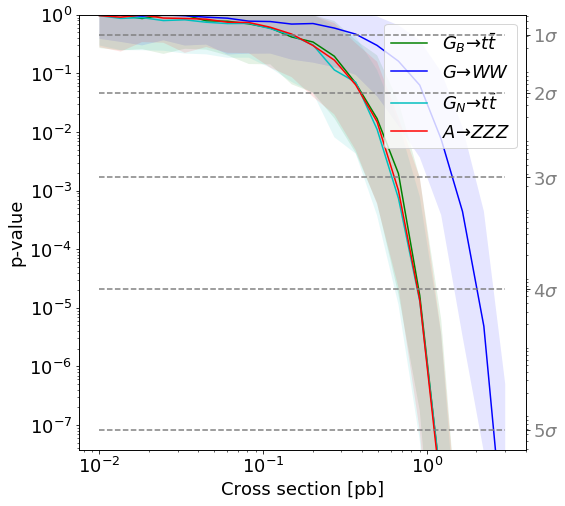

In [10]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(8,8))

for n, val_aux in dic_p_val.iteritems():
    val_aux = np.array(val_aux)
    x_sec = val_aux[:, 0]
    quant = val_aux[:, 1:]
    
    ax1.plot(x_sec, quant[:, 2], color=sample_col[n], label=sample_label[n])
    ax1.fill_between(x_sec, quant[:, 1], quant[:, 3], color=sample_col[n], alpha = 0.1, lw=0)
#     ax1.fill_between(x_sec, quant[:, 0], quant[:, 4], color=sample_col[n], alpha = 0.1, lw=0)
    
    
plt.xscale('log')
plt.xlabel('Cross section [pb]')
plt.yscale('log')
plt.ylabel('p-value')
plt.ylim(1 - erf(5.5/np.sqrt(2)), 1)
plt.legend(loc='upper right')
ax2 = ax1.twinx()
for i in range(1, 6):
    p = 1 - erf(i/np.sqrt(2))
    ax2.plot([x_sec[0], x_sec[-1]], 2*[p], '--', color='grey')
plt.yscale('log')
ax2.set_yticks(1 - erf(np.arange(1,6)/np.sqrt(2)))
ax2.set_yticklabels(['{}$\sigma$'.format(i) for i in range(1,6)])
ax2.tick_params(axis='y', labelcolor='grey')

fig.savefig('../fig/ModelDependentAnalysis_roofit/' + 'pValueScan_L' + str(lumi) + 'pb-1.png', bbox_inches='tight')